In [0]:
from __future__ import print_function
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt

In [0]:
class parameter():
  def __init__(self):
    self.lr=0.0002
    self.niter=10
    self.beta1=0.05
    self.outf='./unet'
    self.batchSize=64
    self.imageSize=64
    self.workers=2
    self.manualSeed = 42 #random.randint(1, 10000)
    self.ngpu=1
    self.nz=100
    self.ngf=100
    self.ndf=100
    self.nEncode=self.nz
opt=parameter()

In [3]:


print("Random Seed: ", opt.manualSeed)
random.seed(opt.manualSeed)
torch.manual_seed(opt.manualSeed)

cuda=1
if torch.cuda.is_available() and not cuda:
    print("WARNING: You have a CUDA device, so you should probably run with --cuda")
dataroot="./data"
dataset='cifar10'
if dataset == 'cifar10':
    dataset = dset.CIFAR10(root=dataroot, train=True, download=True,
                           transform=transforms.Compose([
                               transforms.Resize(opt.imageSize),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
    nc=3

assert dataset
dataloader = torch.utils.data.DataLoader(dataset, batch_size=opt.batchSize,
                                         shuffle=True, num_workers=int(opt.workers))


testDset=dset.CIFAR10(root=dataroot, train=False, download=True,
                           transform=transforms.Compose([
                               transforms.Resize(opt.imageSize),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, ), (0.5, )),
                           ]))
testLoader= torch.utils.data.DataLoader(testDset, batch_size=opt.batchSize,
                                         shuffle=True, num_workers=int(opt.workers))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

ngpu = int(opt.ngpu)
nz = int(opt.nz)
ngf = int(opt.ngf)
ndf = int(opt.ndf)
nEncode=int(opt.nEncode)

# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)




0it [00:00, ?it/s]

Random Seed:  42


170500096it [00:01, 86349952.19it/s]                               


Files already downloaded and verified


In [4]:
class downBlock(torch.nn.Module):
    def __init__(self, D_in, D_out):
        """
        In the constructor we instantiate two nn.Linear modules and assign them as
        member variables.
        """
        super(downBlock, self).__init__()
        self.main=nn.Sequential(
            nn.Conv2d(D_in, D_out, 4, 2, 1, bias=False),
            nn.BatchNorm2d(D_out),
            nn.LeakyReLU(0.2, inplace=True),
        )

    def forward(self, input):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.
        """
        out=self.main(input)
        return out
class upBlock(torch.nn.Module):
    def __init__(self, D_in, D_out):
        """
        In the constructor we instantiate two nn.Linear modules and assign them as
        member variables.
        """
        super(upBlock, self).__init__()
        self.main=nn.Sequential(
            nn.ConvTranspose2d(D_in, D_out, 4, 2, 1, bias=False),
            nn.BatchNorm2d(D_out),
            nn.ReLU(True),
        )
        
    def forward(self, input):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.
        """
        out=self.main(input)
        return out

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        
        
        
#         self.compressor=nn.Sequential(
#             # input is (nc) x 64 x 64
#             nn.Conv2d(1, ndf, 4, 2, 1, bias=False),
#             nn.LeakyReLU(0.2, inplace=True),
#             # state size. (ndf) x 32 x 32
#             nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(ndf * 2),
#             nn.LeakyReLU(0.2, inplace=True),
#             # state size. (ndf*2) x 16 x 16
#             nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(ndf * 4),
#             nn.LeakyReLU(0.2, inplace=True),
#             # state size. (ndf*4) x 8 x 8
#             nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(ndf * 8),
#             nn.LeakyReLU(0.2, inplace=True),
#             # state size. (ndf*8) x 4 x 4
#             nn.Conv2d(ndf * 8, nEncode, 4, 1, 0, bias=False),
#             nn.Tanh(),            
#         )
        
        self.encode0=nn.Sequential(
            # input is (1) x 64 x 64 (grayScale)
            nn.Conv2d(1, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
        )
        
        # state size. (ndf) x 32 x 32
        self.encode1=downBlock(ndf,ndf*2)
        
        # state size. (ndf*2) x 16 x 16
        self.encode2=downBlock(ndf*2,ndf*4)
        
         # state size. (ndf*4) x 8 x 8
        self.encode3=downBlock(ndf*4,ndf*8)
        
        # state size. (ndf*8) x 4 x 4
        self.encodeLatent=nn.Sequential(
            nn.Conv2d(ndf * 8, nEncode, 4, 1, 0, bias=False),
            nn.Tanh(),            
        )
        
        
        
        
#         self.main = nn.Sequential(
            
#             # input is Z, going into a convolution
#             nn.ConvTranspose2d(     nz+nEncode, ngf * 8, 4, 1, 0, bias=False),
#             nn.BatchNorm2d(ngf * 8),
#             nn.ReLU(True),
#             # state size. (ngf*8) x 4 x 4
#             nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(ngf * 4),
#             nn.ReLU(True),
#             # state size. (ngf*4) x 8 x 8
#             nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(ngf * 2),
#             nn.ReLU(True),
#             # state size. (ngf*2) x 16 x 16
#             nn.ConvTranspose2d(ngf * 2,     ngf, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(ngf),
#             nn.ReLU(True),
#             # state size. (ngf) x 32 x 32
#             nn.ConvTranspose2d(    ngf,      nc, 4, 2, 1, bias=False),
#             nn.Tanh()
#             # state size. (nc) x 64 x 64
#         )
        
        # input is [Z_encode;Z_noise], going into a convolution       
        self.decodeLatent=nn.Sequential(            
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz+nEncode, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
        )
        # state size. (ngf*8) x 4 x 4
        
        self.decode3=upBlock(ngf*8*2,ngf*4)
        # state size. (ngf*4) x 8 x 8
        
      
        self.decode2=upBlock(ngf*4*2,ngf*2)
        # state size. (ngf*2) x 16 x 16
        
        self.decode1=upBlock(ngf*2*2,ngf)
        # state size. (ngf) x 32 x 32
        
        self.decode0=nn.Sequential(            
            nn.ConvTranspose2d(    ngf*2,      nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )
        

        
        
        

    def forward(self, img,noise):
#         if img.is_cuda and self.ngpu > 1:
#             output = nn.parallel.data_parallel(self.main, img, range(self.ngpu))
#         else:
        x1 = self.encode0(img)
        x2 = self.encode1(x1)
        x3 = self.encode2(x2)
        x4 = self.encode3(x3)
        z_encode=self.encodeLatent(x4)
        Z=torch.cat((z_encode, noise), 1)
        y4=self.decodeLatent(Z)
        y3=self.decode3(torch.cat((x4, y4), 1))
        y2=self.decode2(torch.cat((x3, y3), 1))
        y1=self.decode1(torch.cat((x2, y2), 1))
        y0=self.decode0(torch.cat((x1, y1), 1))
        output=y0
#         x=self.compressor(img)
#         Z=torch.cat((x, noise), 1)
#         output=self.main(Z)
        
        

        return output


netG = Generator(ngpu).to(device)
netG.apply(weights_init)

print(netG)


class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input,original):
#         if input.is_cuda and self.ngpu > 1:
#             output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
#         else:
        
#         input=torch.cat((input, original), 1)
        output = self.main(input)

        return output.view(-1, 1).squeeze(1)


netD = Discriminator(ngpu).to(device)
netD.apply(weights_init)

print(netD)

criterion = nn.BCELoss()
criterionMSE=nn.MSELoss()

Generator(
  (encode0): Sequential(
    (0): Conv2d(1, 100, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace)
  )
  (encode1): downBlock(
    (main): Sequential(
      (0): Conv2d(100, 200, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace)
    )
  )
  (encode2): downBlock(
    (main): Sequential(
      (0): Conv2d(200, 400, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace)
    )
  )
  (encode3): downBlock(
    (main): Sequential(
      (0): Conv2d(400, 800, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(800, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): L

In [0]:
!mkdir ./unet

In [6]:
netG = Generator(ngpu).to(device)
netG.apply(weights_init)
netD = Discriminator(ngpu).to(device)
netD.apply(weights_init)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 100, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Conv2d(100, 200, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace)
    (5): Conv2d(200, 400, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace)
    (8): Conv2d(400, 800, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(800, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace)
    (11): Conv2d(800, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [0]:
def GrayScale(colorImg):
  R=colorImg[:,0:1,:,:]
  G=colorImg[:,1:2,:,:]
  B=colorImg[:,2:,:,:]
  return 0.2125* R + 0.7154* G + 0.0721* B

[0/10][0/782] Loss_D: 1.9044 Loss_G: 7.4288 D(x): 0.4569 D(G(z)): 0.4812 / 0.0297


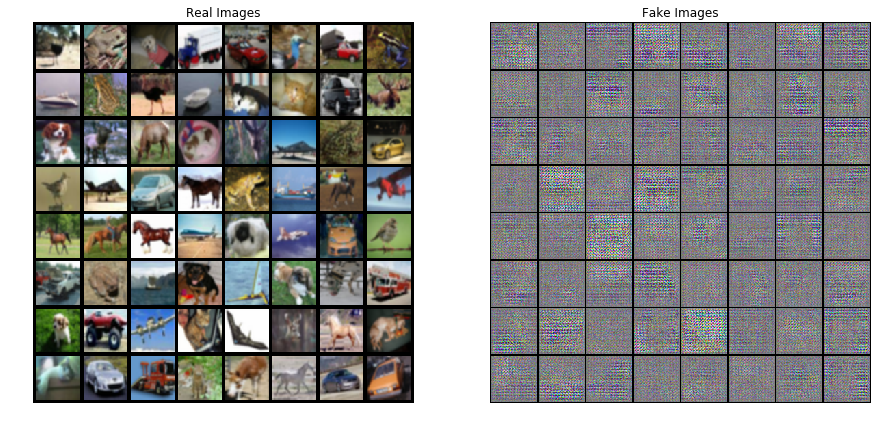

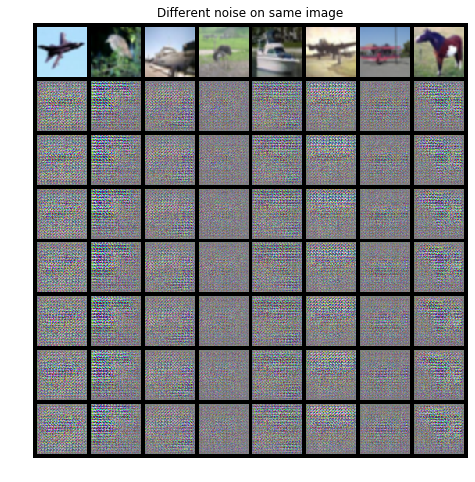

In [0]:
fixed_noise = torch.randn(opt.batchSize, nz, 1, 1, device=device)

for k in range(random.randint(1, 100)):
  iter(testLoader).next()
fixed_sample=iter(testLoader).next()[0]
real_label = 1
fake_label = 0

scale=0.3

# setup optimizer
optimizerD = optim.Adam(netD.parameters(), lr=opt.lr, betas=(opt.beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=opt.lr, betas=(opt.beta1, 0.999))
optimizerH=optim.Adam(netG.parameters(), lr=0.1* opt.lr, betas=(opt.beta1, 0.999))
for epoch in range(opt.niter):
    for i, data in enumerate(dataloader, 0):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        # train with real
        netD.zero_grad()
        real_cpu = data[0].to(device)
        
        grayData=GrayScale(real_cpu)

        
        batch_size = real_cpu.size(0)
        label = torch.full((batch_size,), real_label, device=device)

        output = netD(real_cpu,(grayData.cpu()+torch.randn(grayData.size())*scale).to(device))
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        # train with fake
        
        fake_cpu=grayData.to(device)
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        fake = netG(fake_cpu,noise)
        label.fill_(fake_label)
        output = netD(fake.detach(),(grayData.cpu()+torch.randn(grayData.size())*scale).to(device))
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
#         for k in range(3):
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        output = netD(fake,(grayData.cpu()+torch.randn(grayData.size())*scale).to(device))
        errG = criterion(output, label)
        errG.backward()
        fake = netG(fake_cpu,noise)
        

        
        D_G_z2 = output.mean().item()
        optimizerG.step()
        
        
#         netG.zero_grad()
#         fake = netG(fake_cpu,noise)
#         errReconstruct=criterionMSE(GrayScale(fake), fake_cpu)
#         errReconstruct.backward()   
        
        
#         optimizerH.step()
        if i % 100 == 0:
            print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
                  % (epoch, opt.niter, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        if i % 300 == 0:
            vutils.save_image(real_cpu,
                    '%s/real_samples.png' % opt.outf,
                    normalize=True)
            
            fake = netG(GrayScale(fixed_sample.to(device)),fixed_noise)
            vutils.save_image(fake.detach(),
                    '%s/fake_samples_epoch_%03d.png' % (opt.outf, epoch),
                    normalize=True)
            vutils.save_image(fixed_sample.detach(),
                    '%s/real_samples_epoch_%03d.png' % (opt.outf, epoch),
                    normalize=True)
            
            
            # Plot the real images
            plt.figure(figsize=(15,15))
            plt.subplot(1,2,1)
            plt.axis("off")
            plt.title("Real Images")
            plt.imshow(np.transpose(vutils.make_grid(real_cpu[:64], padding=5, normalize=True).cpu(),(1,2,0)))

            # Plot the fake images from the last epoch
            plt.subplot(1,2,2)
            plt.axis("off")
            plt.title("Fake Images")
            plt.imshow(np.transpose(vutils.make_grid(netG(fake_cpu,noise).detach().cpu(),padding=2, normalize=True),(1,2,0)))
            
            
            plt.figure(figsize=(8,8))
#             plt.subplot(1,2,1)
#             plt.axis("off")
#             plt.title("Same noise on different image")
#             plt.imshow(np.transpose(vutils.make_grid(torch.cat((real_cpu[:8],netG(fake_cpu[:8],noise[0].expand(8, 100, 1, 1)).detach()),0), padding=5, normalize=True).cpu(),(1,2,0)))

            
            
            
            noiseVec=noise[0:7].reshape((7,1,100,1,1)).repeat(1,8,1,1,1).reshape(56,100,1,1)
            noiseVec=torch.randn(56, nz, 1, 1, device=device)
#             plt.subplot(1,2,2)
            plt.axis("off")
            plt.title("Different noise on same image")
            plt.imshow(np.transpose(vutils.make_grid(torch.cat((fixed_sample[0:8].cpu(),netG(GrayScale(fixed_sample).to(device)[0:8].repeat(7,1,1,1),noiseVec).detach().cpu()),0), padding=5, normalize=True).cpu(),(1,2,0)))

      
            
            plt.show()

    # do checkpointing
    torch.save(netG.state_dict(), '%s/netG_epoch_%d.pth' % (opt.outf, epoch))
    torch.save(netD.state_dict(), '%s/netD_epoch_%d.pth' % (opt.outf, epoch))


In [0]:
#download the saved images
!zip ./content.zip ./unet/*.png
from google.colab import files
files.download("./content.zip")